# Solving differential equations (ODEs) for multiple initial conditions.


Ordinary differential equations (ODEs) find applications in various fields, including epidemiology, physics, chemistry, banking, and more. Oftentimes, an ODE system requires integration for multiple initial conditions while keeping parameters constant. Additionally, typical datasets often contain missing values, exhibit different durations, and have irregularly spaced data points. This tutorial expands upon the previous Predator-Prey Model [tutorial](https://num.pyro.ai/en/stable/examples/ode.html) to address these challenges. We will:
    

1.   Define ODEs and the probabilistic model.
2.   Generate synthetic datasets with imperfections.
3.   Perform parameter estimation using the MCMC algorithm.




In [ ]:
#!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [2]:
import functools

import matplotlib.pyplot as plt

import jax
from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, init_to_sample

# Numerical instabilities may arise during ODE solving,
# so one has sometimes to play around with solver settings,
# change solver, or change numeric precision as we do here.
numpyro.enable_x64(True)

## Model

Let's start by defining our differential equations, `dz_dt`, and the probabilistic model, model. The differential equations remain the same as in the Lotka-Volterra tutorial. However, notable changes are introduced in the model to accommodate multiple initial conditions simultaneously. We begin by sampling initial conditions, `z_init`, and parameters, theta. Subsequently, the ODE system is solved in a vectorized form. Vectorization is achieved using `jax.vmap`, with the use of `functools.partial` for passing kwargs. Next, we sample sigma to represent measurement error. Finally, we sample the measured populations. Given that missing values may exist in the observed `y`, we mask non-finite values.

In [3]:
def dz_dt(z, t, theta):
    """
    Lotka–Volterra equations. Real positive parameters `alpha`, `beta`, `gamma`, `delta`
    describes the interaction of two species.
    """
    u, v = z
    alpha, beta, gamma, delta = theta

    du_dt = (alpha - beta * v) * u
    dv_dt = (-gamma + delta * u) * v
    return jnp.stack([du_dt, dv_dt])


def model(ts, y_init, y=None):
    """
    :param numpy.ndarray ts: measurement times
    :param numpy.ndarray y_init: measured inital conditions
    :param numpy.ndarray y: measured populations
    """
    # initial population
    z_init = numpyro.sample(
        "z_init", dist.LogNormal(jnp.log(y_init), jnp.ones_like(y_init))
    )

    # parameters alpha, beta, gamma, delta of dz_dt
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 0.05, 1.0, 0.05]),
            scale=jnp.array([0.2, 0.01, 0.2, 0.01]),
        ),
    )

    # helpers to solve ODEs in a vectorized form
    odeint_with_kwargs = functools.partial(odeint, rtol=1e-6, atol=1e-5, mxstep=1000)
    vect_solve_ode = jax.vmap(
        odeint_with_kwargs,
        in_axes=(None, 0, 0, None),
    )

    # integrate dz/dt
    zs = vect_solve_ode(dz_dt, z_init, ts, theta)
    # measurement errors
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([2]))
    # measured populations
    if y is not None:
        # mask missing observations in the observed y
        mask = jnp.isfinite(jnp.log(y))
        numpyro.sample("y", dist.LogNormal(jnp.log(zs), sigma).mask(mask), obs=y)
    else:
        numpyro.sample("y", dist.LogNormal(jnp.log(zs), sigma))

## Dataset



For the purpose of this tutorial, we will utilize synthetic datasets generated by sampling from the previously defined model. To emulate the non-ideal properties of real-life datasets, we will introduce missing values, varying durations, and irregular spacing between timepoints. It's important to note that JAX works with vectorized and compiled calculations, requiring datasets to have the same length. In our case, although we have different spacing, we maintain the same number of points. If it's not the case one can use `jnp.pad` to extend all datasets to the same length with dummy fill values, which can later be masked.


First, let's establish simulation settings. The datasets will exhibit varying timespans between `t_min` and `t_max`, with the number of points constrained between `n_points_min` and `n_points_max`. Additionally, we will introduce missing values with a probability of `p_missing`.

In [4]:
n_datasets = 3  # int n_datasets: number of datasets to generate
t_min = 100  # int t_min: minimal allowed length of the generated time array
t_max = 200  # int t_min: maximal allowed length of the generated time array
n_points_min = 80  # int n_points_min: minimal allowed number of points in a data set
n_points_max = 120  # int n_points_max: maximal allowed number of points in a data set
y0_min = 2.0  # float y0_min: minimal allowed value for initial conditions
y0_max = 10.0  # float y0_max: maximal allowed value for initial conditions
p_missing = 0.1  # float p_missing: probability of having missing values

Generate an array with initial conditons

In [5]:
# generate an array with initial conditons
z_inits = jnp.array(
    [jnp.linspace(y0_min, y0_max, n_datasets), jnp.linspace(y0_max, y0_min, n_datasets)]
).T

print(f"Initial conditons are: \n {z_inits}")

Initial conditons are: 
 [[ 2. 10.]
 [ 6.  6.]
 [10.  2.]]


Next, let's create a time matrix `ts` to store the time points for each individual dataset. We will generate random integers in `rand_duration` between `t_min` and `t_max` to represent varying durations. Similarly, `rand_n_points` will correspond to different spacings in each dataset. Since JAX requires a matrix with a constant shape, we will use `jnp.pad` to pad individual observations to the common length of the longest array.

In [6]:
# generate array with random integers between t_min and t_max, representing tiem duration in the data set
rand_duration = jax.random.randint(
    PRNGKey(1), shape=(n_datasets,), minval=t_min, maxval=t_max
)

# generate array with random integers between n_points_min and n_points_max,
# representing number of time points per dataset
rand_n_points = jax.random.randint(
    PRNGKey(1), shape=(n_datasets,), minval=n_points_min, maxval=n_points_max
)

# Note that arrays have different length and are stored in a list
time_arrays = [
    jnp.linspace(0, j, num=rand_n_points[i]).astype(float)
    for i, j in enumerate(rand_duration)
]
longest = jnp.max(jnp.array([len(i) for i in time_arrays]))

# Make a time matrix
ts = jnp.array(
    [
        jnp.pad(arr, pad_width=(0, longest - len(arr)), constant_values=jnp.nan)
        for arr in time_arrays
    ]
)

print(f"The shape of the time matrix is {ts.shape}")
print(f"First values are \n {ts[:, :10]}")
print(f"Last values are \n {ts[:, -10:]}")

The shape of the time matrix is (3, 108)
First values are 
 [[ 0.          1.00934579  2.01869159  3.02803738  4.03738318  5.04672897
   6.05607477  7.06542056  8.07476636  9.08411215]
 [ 0.          1.23863636  2.47727273  3.71590909  4.95454545  6.19318182
   7.43181818  8.67045455  9.90909091 11.14772727]
 [ 0.          1.21212121  2.42424242  3.63636364  4.84848485  6.06060606
   7.27272727  8.48484848  9.6969697  10.90909091]]
Last values are 
 [[ 98.91588785  99.92523364 100.93457944 101.94392523 102.95327103
  103.96261682 104.97196262 105.98130841 106.99065421 108.        ]
 [         nan          nan          nan          nan          nan
           nan          nan          nan          nan          nan]
 [118.78787879 120.                  nan          nan          nan
           nan          nan          nan          nan          nan]]


We'll utilize the `Predictive` mode from NumPyro to draw a single sample, representing our synthetic dataset. Subsequently, we'll apply a mask with NaNs to the data to simulate missing values. For simplicity, we'll ensure that initial values are non-missing. In real datasets where this may not hold true, then various imputation methods can be applied.

In [7]:
# take a single sample that will be our synthetic data
sample = Predictive(model, num_samples=1)(PRNGKey(100), ts, z_inits)
data = sample["y"][0]

# create a mask that will add missing values to the data
missing_obs_mask = jax.random.choice(
    PRNGKey(1),
    jnp.array([True, False]),
    shape=data.shape,
    p=jnp.array([p_missing, 1 - p_missing]),
)
# make sure that initial values are not missing
missing_obs_mask = missing_obs_mask.at[:, 0, :].set(False)

# data with missing values
data = data.at[missing_obs_mask].set(jnp.nan)

Finally, for compatibility with `NUTS` later on, we need to fill NaN values in the time matrix `ts` with dummy variables. The `odeint` function from JAX requires these values to be in increasing order. We fill them with values greater than `t_max` from the time matrix. Importantly, these values do not affect the MCMC estimation, as the corresponding values in the `data` are missing and thereby ignored during the posterior estimation.

In [8]:
# fill_nans
def fill_nans(ts):
    n_nan = jnp.sum(jnp.isnan(ts))
    if n_nan > 0:
        loc_first_nan = jnp.where(jnp.isnan(ts))[0][0]
        ts_filled_nans = ts.at[loc_first_nan:].set(
            jnp.linspace(t_max, t_max + 20, n_nan)
        )
        return ts_filled_nans
    else:
        return ts


ts_filled_nans = jnp.array([fill_nans(t) for t in ts])

Let's briefly summarize our synthetic dataset:

In [9]:
print(f"The dataset has the shape {data.shape}, (n_datasets, n_points, n_observables)")
print(f"The time matrix has the shape {ts.shape}, (n_datasets, n_timepoints)")
print(f"The time matrix has different spacing between timepoints: \n {ts[:, :5]}")
print(f"The final timepoints are: {jnp.nanmax(ts, 1)} years.")
print(
    f"The dataset has {jnp.sum(jnp.isnan(data)) / jnp.size(data):.0%} missing observations"
)
print(f"True params mean: {sample['theta'][0]}")

The dataset has the shape (3, 108, 2), (n_datasets, n_points, n_observables)
The time matrix has the shape (3, 108), (n_datasets, n_timepoints)
The time matrix has different spacing between timepoints: 
 [[0.         1.00934579 2.01869159 3.02803738 4.03738318]
 [0.         1.23863636 2.47727273 3.71590909 4.95454545]
 [0.         1.21212121 2.42424242 3.63636364 4.84848485]]
The final timepoints are: [108. 109. 120.] years.
The dataset has 19% missing observations
True params mean: [0.78770691 0.05049109 0.89073622 0.05296055]


Let's visualize the dataset, with solid lines helping to guide the eye. You'll notice line breaks where NaN values occur.

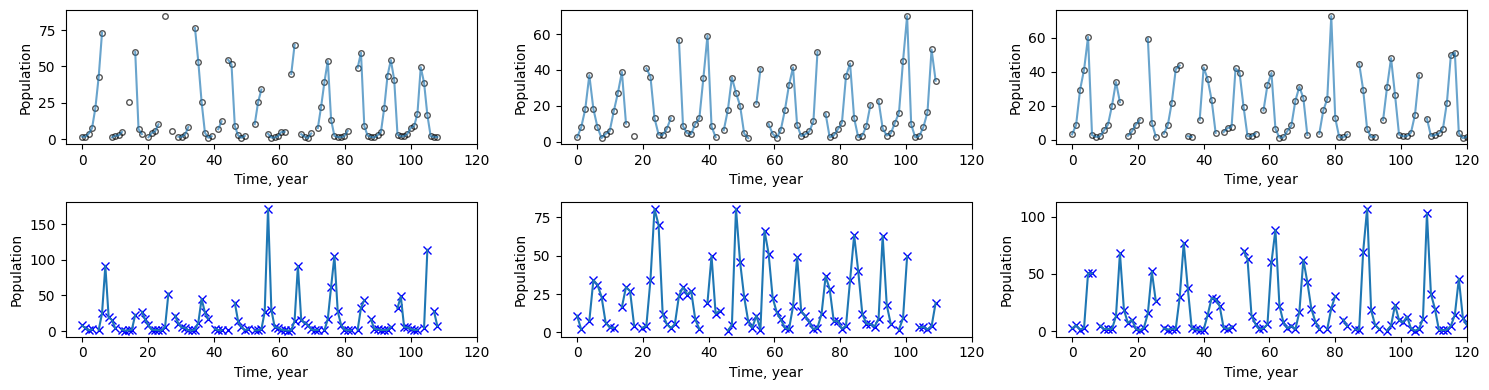

In [10]:
# Plotting
fig, axs = plt.subplots(2, n_datasets, figsize=(15, 4))

for i in range(n_datasets):
    loc = jnp.where(jnp.isfinite(data[i, :, 0]))[0][-1]

    axs[0, i].plot(
        ts[i, :], data[i, :, 0], "ko", mfc="none", ms=4, label="true hare", alpha=0.67
    )
    axs[0, i].plot(ts[i, :], data[i, :, 0], label="true hare", alpha=0.67)
    axs[0, i].set_xlabel("Time, year")
    axs[0, i].set_ylabel("Population")
    axs[0, i].set_xlim([-5, jnp.nanmax(ts)])

    axs[1, i].plot(ts[i, :], data[i, :, 1], "bx", label="true lynx")
    axs[1, i].plot(ts[i, :], data[i, :, 1], label="true lynx")
    axs[1, i].set_xlabel("Time, year")
    axs[1, i].set_ylabel("Population")
    axs[1, i].set_xlim([-5, jnp.nanmax(ts)])

fig.tight_layout()

## Perform MCMC.



To achieve a balance between accuracy and speed, one has to adjust the parameters of both the MCMC solver and the ODE solver to suit the specific problem.

In [11]:
y_init = data[:, 0, :]

mcmc = MCMC(
    NUTS(
        model,
        dense_mass=True,
        init_strategy=init_to_sample(),
        max_tree_depth=10,
    ),
    num_warmup=1000,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,
)

mcmc.run(PRNGKey(1031410), ts=ts_filled_nans, y_init=y_init, y=data)
mcmc.print_summary()

print(f"True params mean: {sample['theta'][0]}")
print(f"Estimated params mean: {jnp.mean(mcmc.get_samples()['theta'], axis=0)}")

sample: 100%|██████████| 2000/2000 [09:09<00:00,  3.64it/s, 31 steps of size 1.23e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
   sigma[0]      0.29      0.01      0.29      0.27      0.31   1064.77      1.00
   sigma[1]      0.51      0.02      0.51      0.47      0.55   1593.43      1.00
   theta[0]      0.77      0.02      0.77      0.74      0.79    760.41      1.00
   theta[1]      0.05      0.00      0.05      0.05      0.05    888.74      1.00
   theta[2]      0.91      0.02      0.91      0.87      0.94    842.09      1.00
   theta[3]      0.06      0.00      0.06      0.05      0.06    858.84      1.00
z_init[0,0]      1.51      0.05      1.51      1.43      1.60    782.07      1.00
z_init[0,1]      9.11      0.55      9.09      8.06      9.88   1072.88      1.00
z_init[1,0]      3.83      0.14      3.83      3.63      4.07    986.01      1.00
z_init[1,1]      8.54      0.57      8.54      7.66      9.52    945.91      1.00
z_init[2,0]      3.87      0.15      3.86      3.64      4.11   1210.24      1.00
z_init[2,1]    

## Run predictions.

In [12]:
# predict
ts_pred = jnp.tile(jnp.linspace(0, 200, 1000), (n_datasets, 1))
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(1041140), ts_pred, y_init)["y"]
mu = jnp.mean(pop_pred, 0)
pi = jnp.percentile(pop_pred, jnp.array([10, 90]), 0)


print(f"True params mean: {sample['theta'][0]}")
print(f"Estimated params mean: {jnp.mean(mcmc.get_samples()['theta'], axis=0)}")

True params mean: [0.78770691 0.05049109 0.89073622 0.05296055]
Estimated params mean: [0.7684689  0.05000161 0.90749349 0.05559383]


Plot the observed points and predicted mean with prediction intervals.



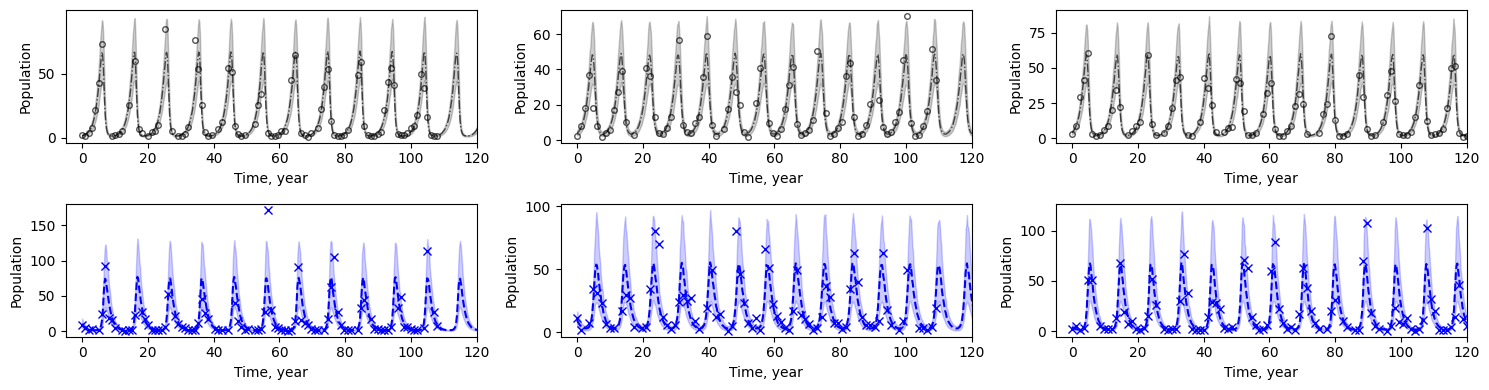

In [13]:
# Plotting
fig, axs = plt.subplots(2, n_datasets, figsize=(15, 4))

for i in range(n_datasets):
    loc = jnp.where(jnp.isfinite(data[i, :, 0]))[0][-1]

    axs[0, i].plot(
        ts_pred[i, :], mu[i, :, 0], "k-.", label="pred hare", lw=1, alpha=0.67
    )
    axs[0, i].plot(
        ts[i, :], data[i, :, 0], "ko", mfc="none", ms=4, label="true hare", alpha=0.67
    )
    axs[0, i].fill_between(
        ts_pred[i, :], pi[0, i, :, 0], pi[1, i, :, 0], color="k", alpha=0.2
    )
    axs[0, i].set_xlabel("Time, year")
    axs[0, i].set_ylabel("Population")
    axs[0, i].set_xlim([-5, jnp.nanmax(ts)])

    axs[1, i].plot(ts_pred[i, :], mu[i, :, 1], "b--", label="pred lynx")
    axs[1, i].plot(ts[i, :], data[i, :, 1], "bx", label="true lynx")
    axs[1, i].fill_between(
        ts_pred[i, :], pi[0, i, :, 1], pi[1, i, :, 1], color="b", alpha=0.2
    )
    axs[1, i].set_xlabel("Time, year")
    axs[1, i].set_ylabel("Population")
    axs[1, i].set_xlim([-5, jnp.nanmax(ts)])


fig.tight_layout()